In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

# SMOTE
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Model selection
from sklearn.model_selection import train_test_split

# Model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, cross_val_predict

from statistics import mean

In [ ]:
data = pd.read_csv('card_transdata.csv')

In [ ]:
#Exploratory data analysis...
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
data.info()
# no missing values
# 1000000 entries
# all float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [ ]:
data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
counts = data['fraud'].value_counts()
total = data['fraud'].count()
print('Fraudulent transactions', counts[1])
print(counts[1] / total * 100, '% of total transactions')

Fraudulent transactions 87403
8.7403 % of total transactions


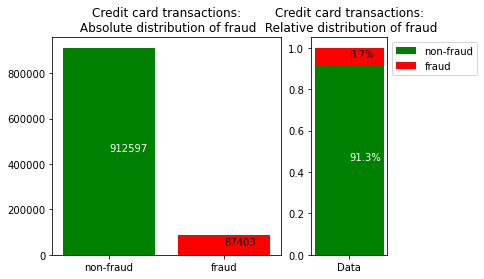

In [ ]:
# Distribution of fraud in data
counts_norm = counts/counts.sum()
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1])

abs_distribution = plt.subplot(gs[0])
abs_distribution = plt.bar(['non-fraud', 'fraud'], counts, color=['g', 'r'])
abs_distribution = plt.title('Credit card transactions:\n Absolute distribution of fraud')
abs_distribution = plt.text(['non-fraud'], counts[0]/2, counts[0], color = 'w')
abs_distribution = plt.text(['fraud'], counts[1]/2, counts[1])

rel_distribution = plt.subplot(gs[1])
rel_distribution = plt.bar(['Data'], [counts_norm[0]], label='non-fraud', color=['g'])
rel_distribution = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='fraud', color=['r'])
rel_distribution = plt.legend(bbox_to_anchor=(1, 1))
rel_distribution = plt.title('Credit card transactions:\n Relative distribution of fraud')
rel_distribution = plt.text(['Data'], counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)), color = 'w')
rel_distribution = plt.text(['Data'], counts_norm[1]/2 + counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

In [ ]:
# distance_from_home, distance_from_last_transaction, ratio_to_median_purchase_price have big max outliers but most values are small
# histograms without top 1 percentile of values

dfh_p99 = data[data['distance_from_home'] < data['distance_from_home'].quantile(.99)]
dfh_p99.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000
mean,22.135917,5.037421,1.824456,0.880339,0.350436,0.100635,0.650591,0.083855
std,33.584109,25.903138,2.801615,0.324564,0.477107,0.300845,0.476784,0.277170
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.834393,0.296708,0.475552,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.793557,0.998843,0.997794,1.000000,0.000000,0.000000,1.000000,0.000000
75%,24.903841,3.356634,2.096615,1.000000,1.000000,0.000000,1.000000,0.000000
max,259.943888,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


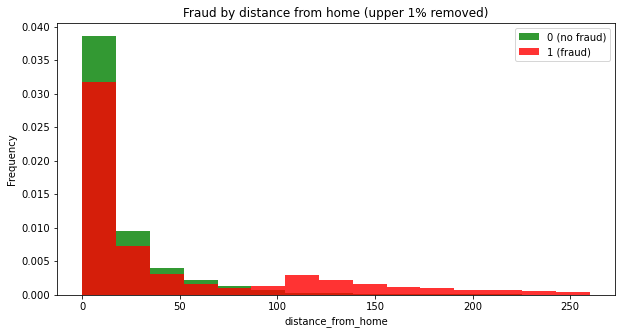

In [ ]:
# Fraud by distance from home (upper 1% removed)
ax = dfh_p99['distance_from_home'].loc[dfh_p99['fraud'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no fraud)', figsize = (10,5), color = 'g')
ax = dfh_p99['distance_from_home'].loc[dfh_p99['fraud'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (fraud)', figsize = (10,5), color = 'r')
ax.set_xlabel('distance_from_home')
ax.set_title('Fraud by distance from home (upper 1% removed)')
ax.legend()
# less fraud when close to home?

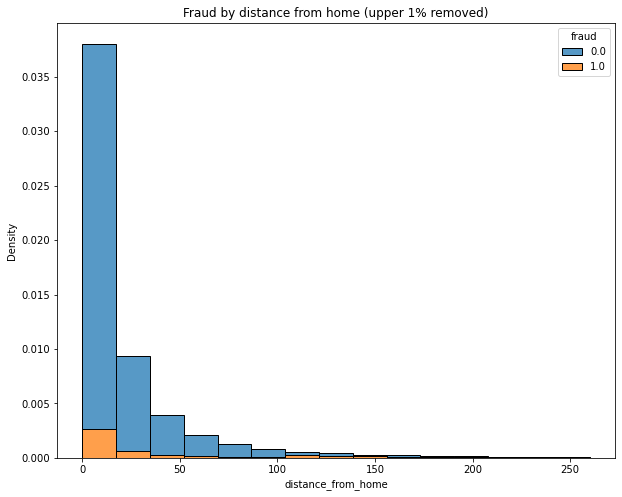

In [ ]:
# Fraud by distance from home (upper 1% removed)
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=dfh_p99, x='distance_from_home', hue='fraud', multiple='stack', stat='density', bins=15, linewidth=1)
ax.set_title('Fraud by distance from home (upper 1% removed)');

In [ ]:
dflt_p99 = data[data['distance_from_last_transaction'] < data['distance_from_last_transaction'].quantile(.99)]
dflt_p99.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000
mean,26.629777,3.560952,1.824219,0.881521,0.350378,0.100603,0.650556,0.083477
std,65.404417,7.315927,2.800116,0.323174,0.477088,0.300803,0.476795,0.276602
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.292370,0.475779,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.963894,0.976177,0.997768,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.740930,3.215253,2.096542,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,65.725552,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


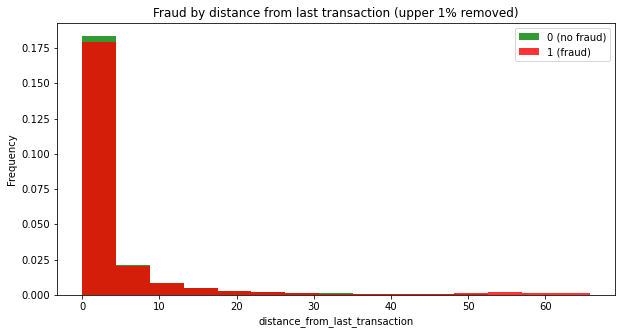

In [ ]:
# Fraud by distance from last transaction (upper 1% removed)
ax = dflt_p99['distance_from_last_transaction'].loc[dflt_p99['fraud'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no fraud)', figsize = (10,5), color = 'g')
ax = dflt_p99['distance_from_last_transaction'].loc[dflt_p99['fraud'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (fraud)', figsize = (10,5), color = 'r')
ax.set_xlabel('distance_from_last_transaction')
ax.set_title('Fraud by distance from last transaction (upper 1% removed)')
ax.legend()
# slightly less fraud when close to last transaction?

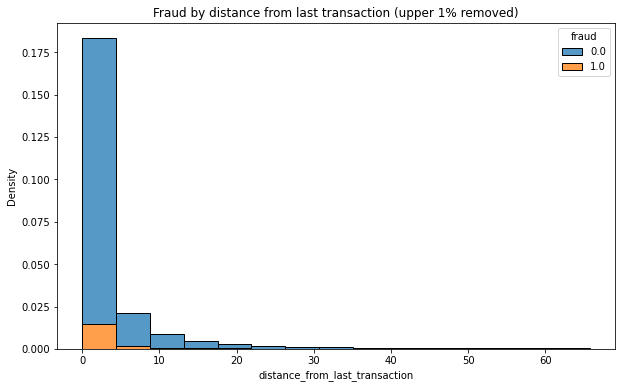

In [ ]:
# Fraud by distance from last transaction (upper 1% removed)
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=dflt_p99, x='distance_from_last_transaction', hue='fraud', multiple='stack', stat='density', bins=15, linewidth=1)
ax.set_title('Fraud by distance from last transaction (upper 1% removed)');

In [ ]:
dfrtmpp_p99 = data[data['ratio_to_median_purchase_price'] < data['ratio_to_median_purchase_price'].quantile(.99)]
dfrtmpp_p99.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000,990000.000000
mean,26.636091,5.032742,1.640735,0.881530,0.350374,0.100609,0.650535,0.081863
std,65.453975,25.849999,1.870977,0.323164,0.477087,0.300811,0.476801,0.274155
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.877813,0.296640,0.471548,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.966168,0.998680,0.984369,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.746612,3.355321,2.043378,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,12.794081,1.000000,1.000000,1.000000,1.000000,1.000000


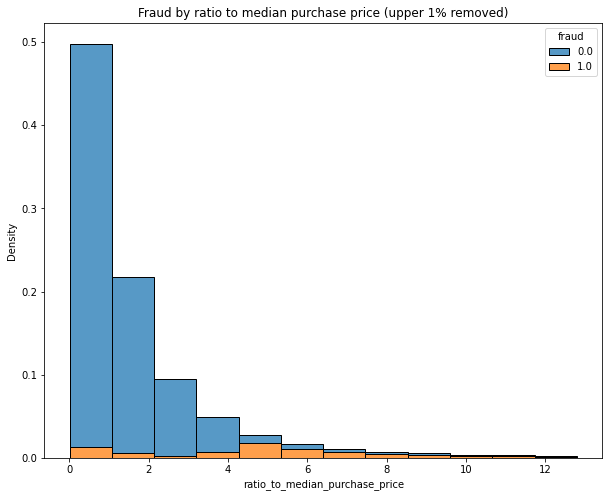

In [ ]:
# Fraud by ratio to median purchase price (upper 1% removed)
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=dfrtmpp_p99, x='ratio_to_median_purchase_price', hue='fraud', multiple='stack', stat='density', bins=12, linewidth=1)
ax.set_title('Fraud by ratio to median purchase price (upper 1% removed)');
# transactions that has ratio > 4 have higher chance being fraud

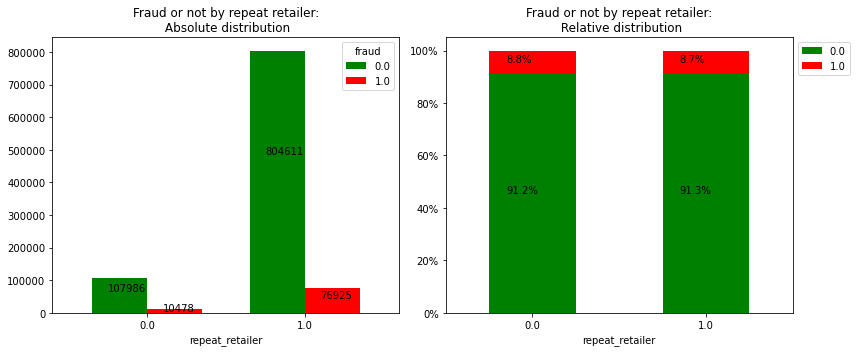

In [ ]:
# Repeat retailer effect on fraud?
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax1 = data.groupby(['repeat_retailer', 'fraud'])['fraud'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7, color = ['g', 'r'])
plt.title('Fraud or not by repeat retailer:\n Absolute distribution')

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))


plt.subplot(1, 2, 2)
ax2 = data.groupby(['repeat_retailer','fraud'])['fraud'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca(), color = ['g', 'r'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Fraud or not by repeat retailer:\n Relative distribution') 

for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

# repeat rerailer has no noticable effect on the percentage of fraudulent transactions

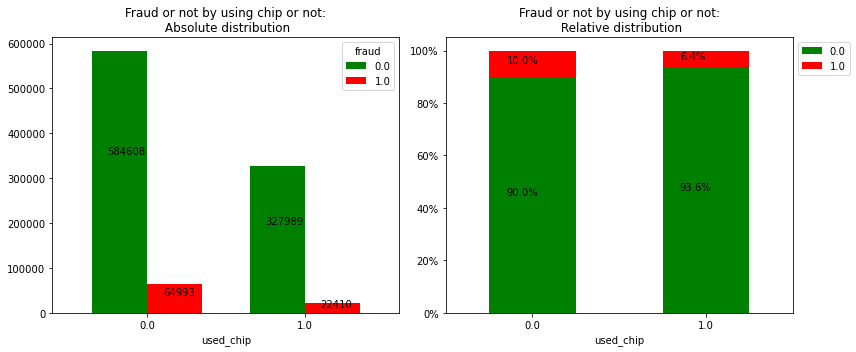

In [ ]:
# Using chip effect on fraud?
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax1 = data.groupby(['used_chip', 'fraud'])['fraud'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7, color = ['g', 'r'])
plt.title('Fraud or not by using chip or not:\n Absolute distribution')

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))


plt.subplot(1, 2, 2)
ax2 = data.groupby(['used_chip','fraud'])['fraud'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca(), color = ['g', 'r'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Fraud or not by using chip or not:\n Relative distribution') 

for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

# Less fraud when using chip!

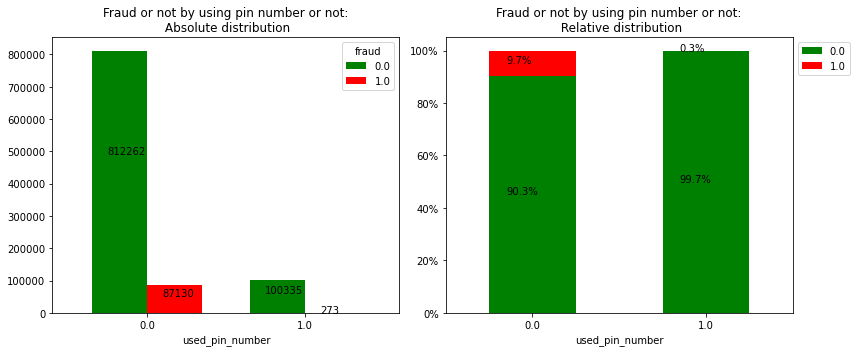

In [ ]:
# Using pin number effect on fraud?
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax1 = data.groupby(['used_pin_number', 'fraud'])['fraud'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7, color = ['g', 'r'])
plt.title('Fraud or not by using pin number or not:\n Absolute distribution')

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))


plt.subplot(1, 2, 2)
ax2 = data.groupby(['used_pin_number','fraud'])['fraud'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca(), color = ['g', 'r'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Fraud or not by using pin number or not:\n Relative distribution') 

for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

# Almost no fraud when pin number used!

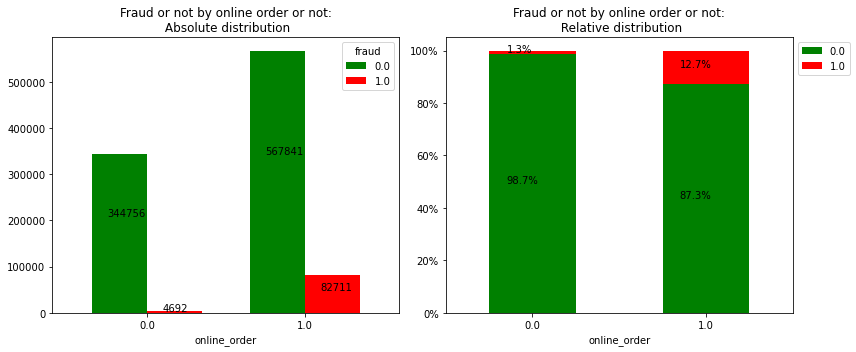

In [ ]:
# Online order effect on fraud?
fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax1 = data.groupby(['online_order', 'fraud'])['fraud'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7, color = ['g', 'r'])
plt.title('Fraud or not by online order or not:\n Absolute distribution')

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))


plt.subplot(1, 2, 2)
ax2 = data.groupby(['online_order','fraud'])['fraud'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca(), color = ['g', 'r'])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Fraud or not by online order or not:\n Relative distribution') 

for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

# significantly more fraud when online order!

## Data preprocessing

In [ ]:
# Make a copy of the dataset
df = data.copy()

# Print out basic statistics of the original dataset
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Remove upper 1% in numeric column
df = df.loc[
    (df['distance_from_home'] < df['distance_from_home'].quantile(0.99)) &
    (df['distance_from_last_transaction'] < df['distance_from_last_transaction'].quantile(0.99)) &
    (df['ratio_to_median_purchase_price'] < df['ratio_to_median_purchase_price'].quantile(0.99))
    ]

# Print out basic statistics of the new dataset
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,970291.000000,970291.000000,970291.000000,970291.000000,970291.000000,970291.000000,970291.000000,970291.000000
mean,22.133865,3.559880,1.640875,0.880319,0.350389,0.100630,0.650578,0.074375
std,33.587537,7.313017,1.870832,0.324588,0.477092,0.300838,0.476788,0.262380
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.833910,0.292369,0.471572,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.788824,0.976375,0.984514,1.000000,0.000000,0.000000,1.000000,0.000000
75%,24.903853,3.215061,2.043765,1.000000,1.000000,0.000000,1.000000,0.000000
max,259.943888,65.725552,12.794081,1.000000,1.000000,1.000000,1.000000,1.000000


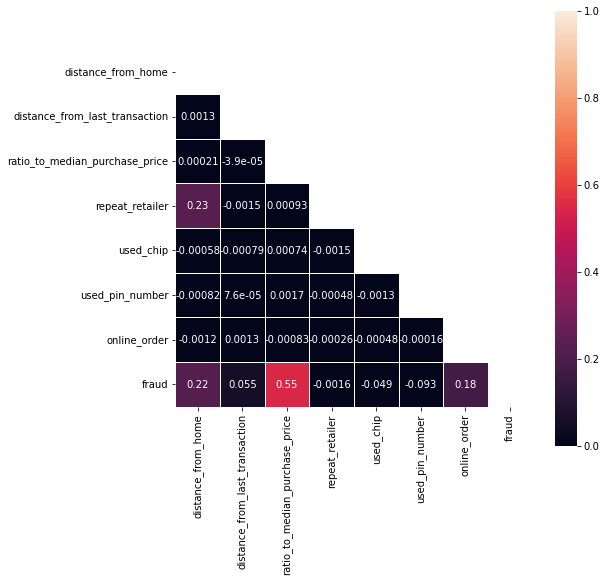

In [ ]:
# Visualize the correlation matrix
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, mask=mask, square=True, linewidth=.5, annot=True, vmin=0, vmax=1);

# The label 'fraud' is highly correlated with features 'ratio_to_purchase_price' (0.55), 'online_order' (0.15), and 'distance_from_home' (0.14).

In [ ]:
# Drop feature 'repeat_retailer' since it has near 0 correlation with label 'fraud'
df.drop(columns='repeat_retailer', inplace=True)

In [ ]:
# Create a feature matrix X and label y
X = df.drop(columns='fraud')
y = df['fraud']

In [ ]:
# Split the rebalance dataset into training set (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Check the number of datapoints in each class before rebalance
y_train.value_counts()

0.0    718521
1.0     57711
Name: fraud, dtype: int64

In [ ]:
# As we have notice before the dataset is highly imbalance
# we will rebalance it using smote
# such that the minority class has the same number of datapoints as the majority class
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

# Check the shape of the new feature matrix and label
print(f"The shape of the feature matrix X is {X_sm.shape}")
print(f"The shape of the label y is {y_sm.shape}")

# Check the number of datapoints in each class after rebalance
y_sm.value_counts()

The shape of the feature matrix X is (1437042, 6)
The shape of the label y is (1437042,)


0.0    718521
1.0    718521
Name: fraud, dtype: int64

In [ ]:
# Logistic Regression model
clf_1 = LogisticRegression(random_state=42)
clf_1.fit(X_sm, y_sm)
y_pred = clf_1.predict(X_test)

# Print the classification report of the Logistic Regression model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    179605
         1.0       0.55      0.96      0.70     14454

    accuracy                           0.94    194059
   macro avg       0.77      0.95      0.83    194059
weighted avg       0.96      0.94      0.95    194059



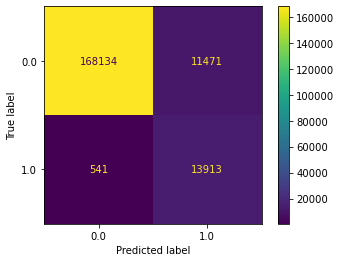

In [ ]:
# Plot the confusion matrix of the Logistic Regression model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [ ]:
# Decision Tree model
clf2 = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=4)
clf2.fit(X_sm, y_sm)
y_pred = clf2.predict(X_test)

# Print the classification report of the Decision Tree model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    179605
         1.0       0.96      1.00      0.98     14454

    accuracy                           1.00    194059
   macro avg       0.98      1.00      0.99    194059
weighted avg       1.00      1.00      1.00    194059



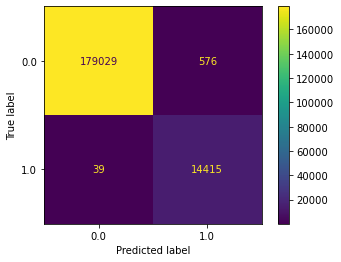

In [ ]:
# Plot the confusion matrix of the Decision Tree model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

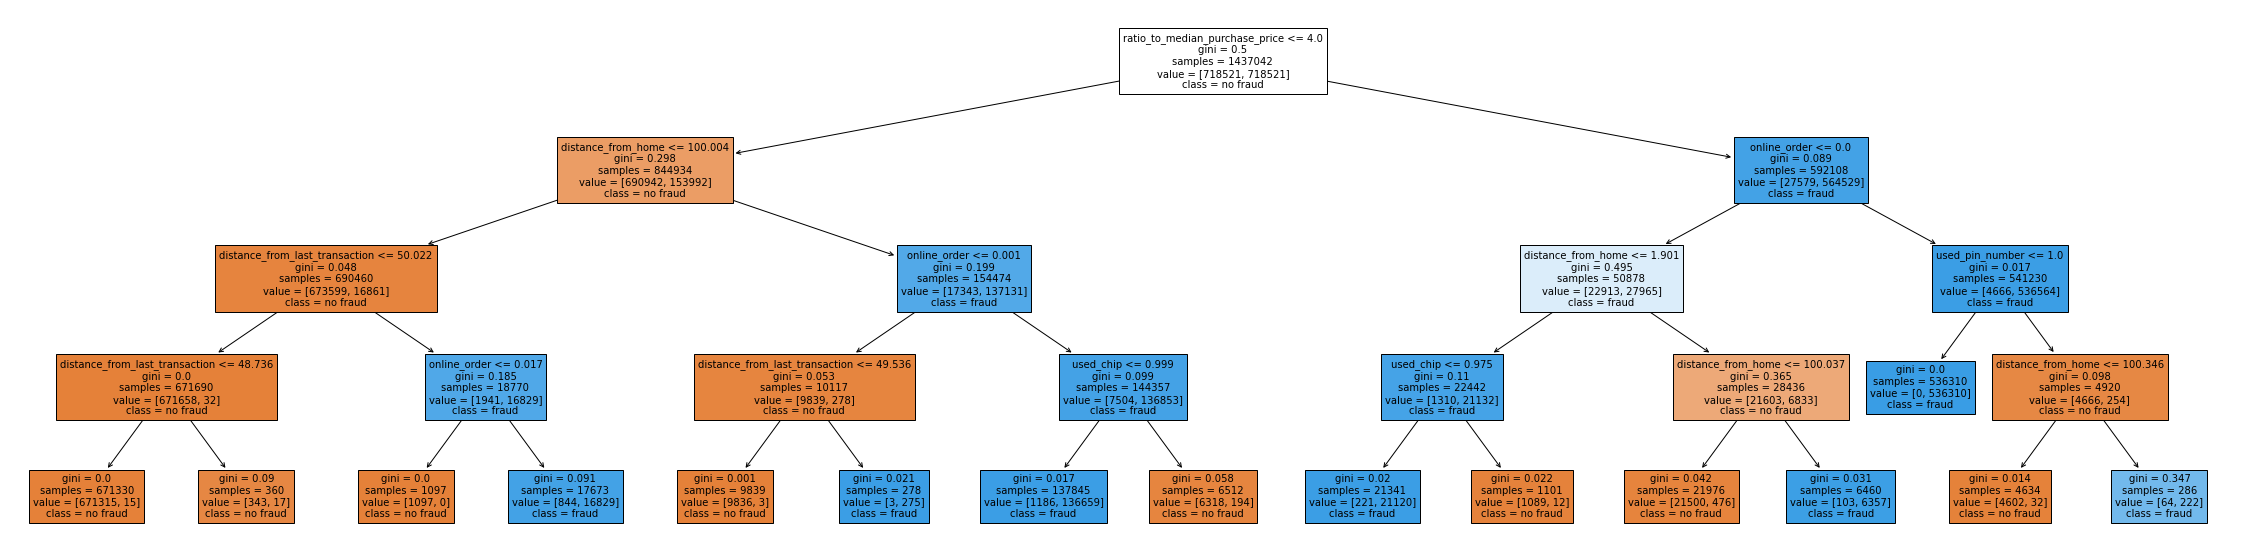

In [ ]:
# Plot the Decision Tree
fig = plt.figure(figsize=(40, 10))
_ = tree.plot_tree(clf2,
                   feature_names=X_train.columns,
                   class_names=['no fraud', 'fraud'],
                   filled=True,
                   fontsize=10)

In [ ]:
# cross validation on logistic regression

skf = StratifiedKFold(n_splits=5)

model = LogisticRegression(random_state=42)

score = cross_val_score(model, X, y, cv = skf)

print("Logistic regression cross validation average accuracy:", mean(score))

Logistic regression cross validation average accuracy: 0.9702862337322578


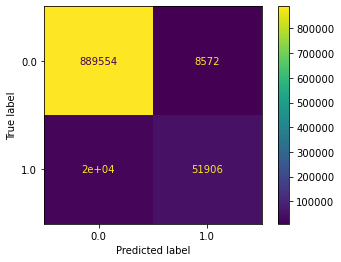

In [ ]:
# confusion matrix logistic regression
y_pred = cross_val_predict(model, X, y, cv = skf)

ConfusionMatrixDisplay.from_predictions(y, y_pred)

Text(0.5, 0, 'False Positive Rate (FPR)')

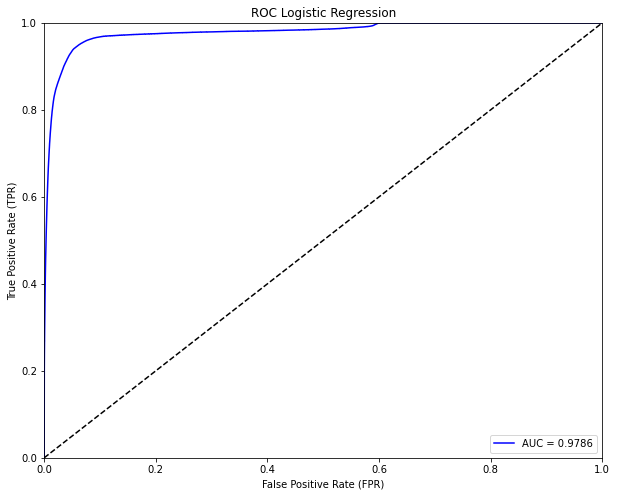

In [ ]:
# roc curve logistic regression

y_pred_proba = cross_val_predict(model, X, y, cv = skf, method='predict_proba')

fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:,1])

#auc score
roc_auc = auc(fpr, tpr)

#roc curve
fig, axs = plt.subplots(1,1, figsize=(10,8))

plt.title('ROC Logistic Regression')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f'% roc_auc)
plt.legend(loc='best')
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

In [ ]:
# cross validation on decision tree

skf = StratifiedKFold(n_splits=5)

model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=4)

score = cross_val_score(model, X, y, cv = skf)

print("Decision tree cross validation average accuracy:", mean(score))

Decision tree cross validation average accuracy: 0.9967205714606013


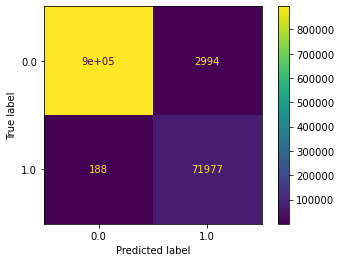

In [ ]:
# confusion matrix decision tree

y_pred = cross_val_predict(model, X, y, cv = skf)

ConfusionMatrixDisplay.from_predictions(y, y_pred)

Text(0.5, 0, 'False Positive Rate (FPR)')

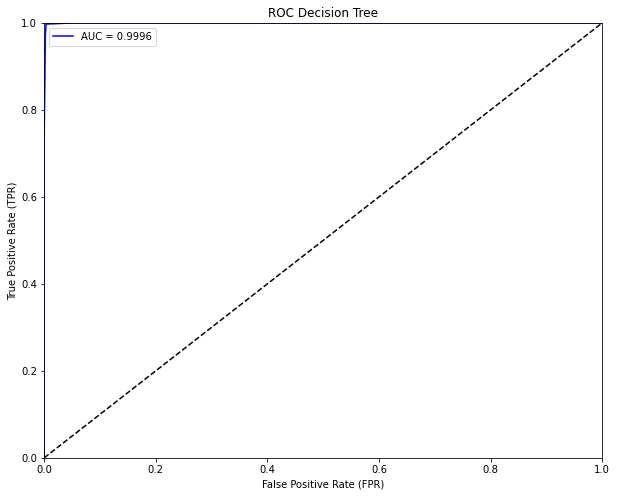

In [ ]:
# roc curve decision tree

y_pred_proba = cross_val_predict(model, X, y, cv = skf, method='predict_proba')

fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:,1])

#auc score
roc_auc = auc(fpr, tpr)

#roc curve
fig, axs = plt.subplots(1,1, figsize=(10,8))

plt.title('ROC Decision Tree')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f'% roc_auc)
plt.legend(loc='best')
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')